# Local STLF with Data Streams

This notebook provides the exemplary code to apply a basic machine learning model for data streams.

In [3]:
#Imports
import pandas as pd
import os
import tensorflow as tf
from scipy.stats import ks_2samp

import sys  
sys.path.append("../../")  
from utils.old.modelgenerator import *
from utils.old.modelhandler import *
from utils.old.datahandler import *

In [4]:
# Setup data
#Get data 
cwd = os.path.normpath(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))))
df = pd.read_csv(cwd+'/data/3final_data/Final_Grossload_dataset.csv', index_col='Date') #df = pd.read_csv('user5.csv')
df.index = pd.to_datetime(df.index)
#df = df[['User5', 'temp', 'rhum']]
df.fillna(0, inplace=True)

df_array = []
for idx in range(1):
    df_array.append(df[[f'User{idx+1}', 'temp', 'rhum', 'wspd', 'PC1', 'hour sin', 'hour cos', f'User{idx+1}_lag_24hrs']])


columns_to_keep = []

for column_name in df.columns:
    if column_name.startswith('User') and column_name[4:].isdigit():
        user_number = int(column_name[4:])
        if 1 <= user_number <= 30:
            columns_to_keep.append(column_name)

filtered_df = df[columns_to_keep]
filtered_df.reset_index(inplace=True)
filtered_df

df_user1 = filtered_df.iloc[:,:2]
half_point = len(df_user1) // 2
df_user1_static = df_user1.iloc[:half_point].copy()
df_user1_dynamic = df_user1.iloc[half_point:].copy()

In [5]:
def create_sequences(data, seq_length):
    """
    Create sequences of input features and target values.

    Parameters:
    - data: 1D array or list of values.
    - seq_length: Length of the sequence.

    Returns:
    - Tuple (X, y) where X is a 2D array of input sequences and y is a 1D array of target values.
    """
    X, y = [], []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        target = data[i+seq_length]
        X.append(seq)
        y.append(target)
    return np.array(X), np.array(y)

In [6]:
# Convert 'Date' column to datetime
df_user1_static['Date'] = pd.to_datetime(df_user1_static['Date'])

# Sort the DataFrame by date
df_user1_static = df_user1_static.sort_values(by='Date')

# Normalize the 'User1' column
scaler = MinMaxScaler()
df_user1_static['User1'] = scaler.fit_transform(df_user1_static[['User1']])

# Split the data into training and testing sets
train_size = int(len(df_user1_static) * 0.5)
train_data, test_data = df_user1_static.iloc[:train_size], df_user1_static.iloc[train_size:]

# Define the TensorFlow model
seq_length = 24  # Past 24 values
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(64, activation='relu', input_shape=(seq_length,)))
model.add(tf.keras.layers.Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model on the first half of the data
X_train, y_train = create_sequences(train_data['User1'].values, seq_length)
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=2)




Epoch 1/10

205/205 - 0s - loss: 0.0151 - 456ms/epoch - 2ms/step
Epoch 2/10
205/205 - 0s - loss: 0.0105 - 110ms/epoch - 537us/step
Epoch 3/10
205/205 - 0s - loss: 0.0102 - 110ms/epoch - 537us/step
Epoch 4/10
205/205 - 0s - loss: 0.0100 - 112ms/epoch - 546us/step
Epoch 5/10
205/205 - 0s - loss: 0.0099 - 111ms/epoch - 541us/step
Epoch 6/10
205/205 - 0s - loss: 0.0098 - 107ms/epoch - 522us/step
Epoch 7/10
205/205 - 0s - loss: 0.0096 - 112ms/epoch - 546us/step
Epoch 8/10
205/205 - 0s - loss: 0.0094 - 112ms/epoch - 546us/step
Epoch 9/10
205/205 - 0s - loss: 0.0093 - 111ms/epoch - 541us/step
Epoch 10/10
205/205 - 0s - loss: 0.0092 - 112ms/epoch - 546us/step


In [7]:
def buffer_data(data, actual_values_buffer, evaluation_interval):
    # Add the current value to the buffer
    actual_values_buffer.append(data)
    # Keep the buffer size to the last 24 values
    if len(actual_values_buffer) > evaluation_interval:
        actual_values_buffer.pop(0)

def make_predictions(actual_values_buffer, stream_predictions):
    window = np.array(actual_values_buffer[-24:]).reshape(1, -1)
    prediction = model.predict(window)[0, 0]
    stream_predictions.append(prediction) 

def evaluate_data_stream(stream_buffer, last_predictions, mae_treshhold, ks_threshold, previous_mae, cd_mae_counter, cd_ks_counter):
    mae = mean_absolute_error(stream_buffer, last_predictions)
    print(f"MAE for the current evaluation window: {mae}")
    
    #Initial intitialization
    if previous_mae == np.NaN: 
        previous_mae = mae

    # Check for concept drift
    if abs(mae - previous_mae) > mae_treshhold:
        print("Concept Drift Detected!")
        cd_mae_counter +=1
    
    # Check for concept drift using KS test
    ks_statistic, ks_p_value = ks_2samp(stream_buffer, last_predictions)
    if ks_p_value < ks_threshold:
        print("Concept Drift Detected using KS test!")
        cd_ks_counter +=1

    return mae, cd_mae_counter, cd_ks_counter

In [8]:
stream_data = df_user1_dynamic['User1'].values
stream_data

array([0.067, 0.149, 0.159, ..., 0.19 , 0.274, 0.166])

In [19]:
# Simulate a data stream using the second half of the data
stream_data = df_user1_dynamic['User1'].values

mae_threshold = 0.1
mae_threshold
ks_threshold = 0.05  # Adjust this based on your significance level
cd_mae_counter = 0
cd_ks_counter = 0
previous_mae = np.NaN

# Store all predictions
stream_predictions = []
# Buffer to store the actual values for evaluation
stream_buffer = []
# Number of values to wait before evaluating the results
evaluation_interval = 168


        
# Apply the model in an incremental way
for idx, data in enumerate(stream_data):
    
    # Buffer the data for prediction and evaluation
    buffer_data(data, stream_buffer, evaluation_interval)
        
    # Predict the next value based on the past 24 values in the buffer
    if len(stream_buffer) >= seq_length:
        make_predictions(stream_buffer, stream_predictions)
           
    
    # Evaluate results every 168 values
    if len(stream_predictions) >= 168 and idx % evaluation_interval == 0:
        mae, cd_mae_counter, cd_ks_counter = evaluate_data_stream(
            stream_buffer, stream_predictions[-evaluation_interval:], mae_threshold, ks_threshold,
            previous_mae, cd_mae_counter, cd_ks_counter
            )
  
    # Simulate a delay to represent the stream's real-time nature
    #time.sleep(1)  # Adjust the delay as needed

print(f"MAE for the current evaluation window: {mae}")
print("Concept drift MAE: ", cd_mae_counter)
print("Concept drift Kolmogorov-Smirnov test: ", cd_ks_counter)

1/1 [==============================] - 0s 13ms/step
MAE for the current evaluation window: 0.13839840985444332
Concept Drift Detected using KS test!
1/1 [==============================] - 0s 13ms/step
MAE for the current evaluation window: 0.1244126109580199
Concept Drift Detected using KS test!
1/1 [==============================] - 0s 13ms/step
MAE for the current evaluation window: 0.13511152818320055
Concept Drift Detected using KS test!
1/1 [==============================] - 0s 13ms/step
MAE for the current evaluation window: 0.11617147442343688
Concept Drift Detected using KS test!
1/1 [==============================] - 0s 14ms/step
MAE for the current evaluation window: 0.14314357847081766
Concept Drift Detected using KS test!
1/1 [==============================] - 0s 13ms/step
MAE for the current evaluation window: 0.14842433267228658
Concept Drift Detected using KS test!
1/1 [==============================] - 0s 13ms/step
MAE for the current evaluation window: 0.12782170439440

KeyboardInterrupt: 

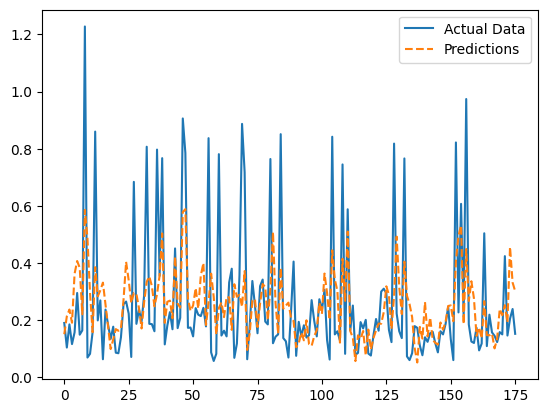

In [ ]:
# Plotting to visualize the results
plt.plot(df_user1_dynamic['User1'][124:300].values, label='Actual Data')
plt.plot(stream_predictions[124:300], label='Predictions', linestyle='dashed')
plt.legend()
plt.show()